In [12]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 22.2 MB/s eta 0:00:00


In [9]:
!pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 19.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4


In [10]:
!pip install opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 22.4 MB/s eta 0:00:0000:0100:01


In [11]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16445 sha256=398b078c2bd5629129334cc6f88ce0100ac5a441792886260094a7416420376b
  Stored in directory: /opt/ml/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet_pytorch


In [93]:
#torch.cuda.is_available()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-32GB'

In [91]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
#import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time
import math

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

from sklearn.metrics import f1_score

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur, RandomRotation, ColorJitter
from efficientnet_pytorch import EfficientNet
from torch.utils.tensorboard import SummaryWriter # 학습 중 실시간으로 acc와 loss 같은 값들을 그래프에 찍어서 보여주는 역할
from torch.optim import lr_scheduler # validation dataset을 학습시킬 때 조정해주는 scheduler
#import dataset_hs

In [92]:
# Set random seed
import random
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [94]:
class MaskDataset(data.Dataset):
    def __init__(self, img_dir, transform=None):

        self.transform = transform
        self.img_dir = img_dir
        self.path = []
        self.label = []
        self.class_num = 18
        self.setup()

    
    def setup(self):
        filenames = os.listdir(self.img_dir)
        for i in filenames:
            if not i.startswith("."):
                img_name = os.listdir(os.path.join(self.img_dir, i))
                for j in img_name:
                    if not j.startswith('.'):
                        self.path.append(i+'/'+j)
                        gender = 0 if i.split('_')[1] == 'male' else 1
                        age = int(i.split('_')[3])
                        age_range = 0 if age < 30 else 1 if age < 60 else 2
                        if 'incorrect' in j:
                            mask = 1
                        elif 'mask' in j:
                            mask=0
                        elif 'normal' in j:
                            mask=2
                        self.label.append(mask * 6 + gender * 3 + age_range)
                
    def __getitem__(self, index):
        y = self.label[index]
        img_path = self.path[index]
    
        img = Image.open(os.path.join(self.img_dir,img_path))
        if self.transform != None:
            X = self.transform(img)
        else:
            tt = transforms.ToTensor()
            X = tt(img)
        return X, y
        
    def __len__(self):
        return len(self.path)

In [95]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체 생성

transform = transforms.Compose([
        Resize((int(512 / 2), int(384/ 2))),
        ToTensor(),
        #Normalize(mean=mean, std=std)
    ])

dataset = MaskDataset(
    img_dir = '/opt/ml/input/data/train/images',
    transform=transform
)

# train dataset, validation dataset 8:2
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

In [96]:

train_loader = data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4, 
#     cuda설정이안돼서 num_workers 설정하면 안돌아감
    shuffle=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=False
)
loader={'train':train_loader,
       'val':val_loader}

In [97]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([16, 3, 256, 192])
labels shape: torch.Size([16])


In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.3/792.3 KB 38.3 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.19.0
    Uninstalling ipython-7.19.0:
      Successfully uninstalled ipython-7.19.0


In [24]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [25]:
#efficientnet은 pytorch에서 기본적으로 제공 되지 않기 때문에 다른 사람이 구현한 efficientnet을 가져와야함
!pip3 install efficientnet_pytorch

In [26]:
!pip install torchsummary

In [53]:
from torchsummary import summary
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=18) # b0~b8호출 가능, 학습시키는 데이터에 대한 num_classes
                                                                        #gpu memory가 8g 아래면 b3을 추천
model.to(device)
torchsummary.summary(model, input_size=(3,256,192))

Loaded pretrained weights for efficientnet-b7


NameError: name 'torchsummary' is not defined

In [99]:
print("입력 채널 개수", model._conv_stem.weight.shape[1])
print("출력 채널(예측 class type 개수)", model._fc.weight.shape[0])

입력 채널 개수 3
출력 채널(예측 class type 개수) 18


In [29]:
# weight및 bias 초기화
torch.nn.init.xavier_uniform_(vision_model._fc.weight)
stdv = 1. / math.sqrt(vision_model._fc.weight.size(1))
vision_model._fc.bias.data.uniform_(-stdv, stdv)

NameError: name 'vision_model' is not defined

In [100]:
learning_rate = 0.0001
num_epoch = 30
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min') 
# ReduceLROnPlateau: val_loss가 향상되지 않고 정체되어 있으면 learning rate를 factor배로 감소시킴(factor 디폴트값:0.1)
# 'min' mode에서는 val_loss가 감소를 멈줬을 때 감소, 'max' mode에서는 val_loss가 증가를 멈췄을 때 감소 (mode 디폴트값:'min')

In [101]:
best_val_accuracy = 0.
best_val_loss = 9999.

torch.cuda.empty_cache()

for epoch in range(num_epoch):
    for phase in ["train", "val"]:
        running_loss = 0.
        running_acc = 0.
        n_iter = 0
        epoch_f1 = 0
        if  phase == "val":
            confusion_matrix = np.zeros((18, 18))

        if phase == "train":
            model.train()
        elif phase == "val":
            model.eval()

        for ind, data in enumerate(tqdm(loader[phase])):
            try:
                images = data[0].to(device)
                labels = data[1].to(device)

                optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

                with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산
                    logits = model(images)
                    _, preds = torch.max(logits, 1)
                    loss = loss_fn(logits, labels)

                    if phase == "train":
                        loss.backward() 
                        optimizer.step()
                # Metrics 계산 부분 ==============================================================================
                epoch_f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
                n_iter += 1
                if  phase == "val":
                    for t, p in zip(labels.view(-1), preds.view(-1)): # confusion matrix에 값 입력, 언제가 최적일 지 몰라 매 epoch돌아감
                        confusion_matrix[t.long(), p.long()] += 1    
                running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값, images.size(0) = batch size
                running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값
            except:
                continue
            
            
    # 한 epoch이 모두 종료
    epoch_loss = running_loss / len(loader[phase].dataset)
    epoch_acc = running_acc / len(loader[phase].dataset)
    epoch_f1 = epoch_f1/n_iter

    print(f"epoch-{epoch}의 {phase}-데이터 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}, 평균 f1:{epoch_f1}")
    if phase == "val" and best_val_accuracy < epoch_acc: 
        best_val_accuracy = epoch_acc
    if phase == "val" and best_val_loss > epoch_loss: 
        best_val_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_val_accuracy:3f}, 최고 낮은 loss : {best_val_loss:3f}")


epoch-0의 val-데이터 평균 Loss : 0.012, 평균 Accuracy : 0.997, 평균 f1:0.9939351321463973



epoch-1의 val-데이터 평균 Loss : 0.015, 평균 Accuracy : 0.996, 평균 f1:0.9929412853980535



epoch-2의 val-데이터 평균 Loss : 0.017, 평균 Accuracy : 0.995, 평균 f1:0.9908687505305619



epoch-3의 val-데이터 평균 Loss : 0.004, 평균 Accuracy : 0.999, 평균 f1:0.9985924956467592



epoch-4의 val-데이터 평균 Loss : 0.003, 평균 Accuracy : 0.999, 평균 f1:0.9970476306024478



epoch-5의 val-데이터 평균 Loss : 0.004, 평균 Accuracy : 0.998, 평균 f1:0.9964058547958369



epoch-6의 val-데이터 평균 Loss : 0.017, 평균 Accuracy : 0.995, 평균 f1:0.991005201554652



epoch-7의 val-데이터 평균 Loss : 0.009, 평균 Accuracy : 0.998, 평균 f1:0.9953263040638454



epoch-8의 val-데이터 평균 Loss : 0.011, 평균 Accuracy : 0.997, 평균 f1:0.9933004416904236



epoch-9의 val-데이터 평균 Loss : 0.011, 평균 Accuracy : 0.997, 평균 f1:0.9946188994140269



epoch-10의 val-데이터 평균 Loss : 0.005, 평균 Accuracy : 0.999, 평균 f1:0.9982070900675551



epoch-11의 val-데이터 평균 Loss : 0.003, 평균 Accuracy : 1.000, 평균 f1:0.9989905807437114



epoch-12의 val-데이터 평균 Loss : 0.012, 평균 Accuracy : 0.998, 평균 f1:0.9949294387168143



epoch-13의 val-데이터 평균 Loss : 0.007, 평균 Accuracy : 0.998, 평균 f1:0.9954325042876027



epoch-14의 val-데이터 평균 Loss : 0.006, 평균 Accuracy : 0.998, 평균 f1:0.9960316771944678



epoch-15의 val-데이터 평균 Loss : 0.001, 평균 Accuracy : 1.000, 평균 f1:0.9990070222628363



epoch-16의 val-데이터 평균 Loss : 0.004, 평균 Accuracy : 0.999, 평균 f1:0.9981916877265715



epoch-17의 val-데이터 평균 Loss : 0.005, 평균 Accuracy : 0.999, 평균 f1:0.9984393052499365



epoch-18의 val-데이터 평균 Loss : 0.009, 평균 Accuracy : 0.997, 평균 f1:0.995878178133055



epoch-19의 val-데이터 평균 Loss : 0.021, 평균 Accuracy : 0.995, 평균 f1:0.988328691119389


FileNotFoundError: [Errno 2] No such file or directory

In [102]:
# 파일을 저장
from pytz import timezone
import datetime as dt

now = (dt.datetime.now().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d-%H-%M"))
#now
torch.save(model,f"save_model/{now}.pth")

Text(0.5, 69.0, 'Predicted label')

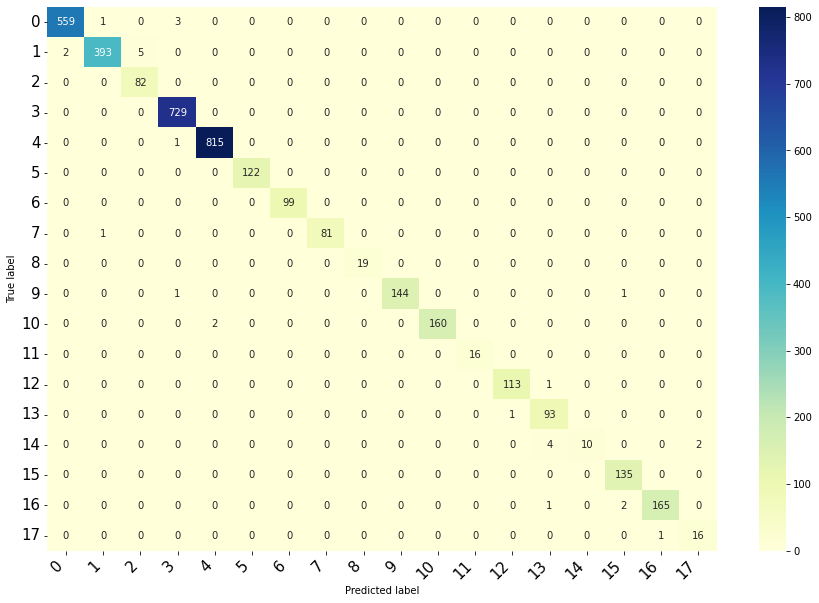

In [42]:
'''
plt.figure(figsize=(15,10))

class_names=[str(i) for i in range(18)]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
'''

In [103]:
model = torch.load(f'save_model/{now}.pth')

In [104]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [105]:
test_dir = 'input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = transforms.Compose([
            Resize((int(512 / 2), int(384/ 2))),
            ToTensor(),
            #Normalize(mean=mean, std=std),
        ])
dataset = TestDataset(image_paths, transform)
loader = DataLoader(
    dataset,
    shuffle=False
)

In [106]:
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = model.to(device)
model.eval()

all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

In [107]:
submission.to_csv(f'submission/submission_4.csv', index=False)
print('test inference is done!')

test inference is done!
